In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, validation_curve
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from pylab import savefig

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(500)

In [3]:
#read csv
tweet_df = pd.read_csv('TrainingHashtag.csv')
tweet_df[['tweet', 'crime', 'Category', 'lemmatized_tweet', 'stemming_tweet']].head(2)

,tweet,crime,Category,lemmatized_tweet,stemming_tweet
0,- she was returning to her hostel when she was...,Yes,1,"['return', 'hostel', 'savagely', 'beat', 'unco...","['return', 'hostel', 'savag', 'beaten', 'uncon..."
1,BBC News - Napier Barracks: Fire at Covid-hit ...,Yes,1,"['bbc', 'news', 'napier', 'barrack', 'fire', '...","['bbc', 'news', 'napier', 'barrack', 'fire', '..."


In [4]:
#train_test split - lemmatized
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(tweet_df['lemmatized_tweet'],
                                                                    tweet_df['Category'], 
                                                                    stratify=tweet_df['Category'], 
                                                                    test_size=0.2,
                                                                   random_state = 42)

#train_test split - lstemmed
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(tweet_df['stemming_tweet'],
                                                                        tweet_df['Category'], 
                                                                        stratify=tweet_df['Category'], 
                                                                        test_size=0.2,
                                                                       random_state = 42)

In [5]:
#shape of train and test sets
print(X_train_lem.shape, y_train_lem.shape)
print(X_test_lem.shape, y_test_lem.shape)

print(X_train_stem.shape, y_train_stem.shape)
print(X_test_stem.shape, y_test_stem.shape)

(1072,) (1072,)
(268,) (268,)
(1072,) (1072,)
(268,) (268,)


In [6]:
X_test_lem 

761     ['nicola', 'sturgeon', 'try', 'salmond', 'jail...
1145    ['police', 'armed', 'still', 'need', 'close', ...
1125    ['job', 'make', 'sure', 'arrest', 'not', 'atte...
0       ['return', 'hostel', 'savagely', 'beat', 'unco...
770     ['use', 'site', 'automatically', 'email', 'twe...
                              ...                        
1144    ['jon', 'give', 'I', 'knife', 'bloody', 'fed',...
709     ['hurt', 'police', 'officer', 'go', 'prison', ...
501     ['cheshunt', 'man', 'use', 'steal', 'debit', '...
915     ['man', 'release', 'serial', 'domestic', 'homi...
1168    ['equivalent', 'war', 'crime', 'crime', 'state...
Name: lemmatized_tweet, Length: 268, dtype: object

In [7]:
#TF-IDF - Lemmatized tweets
Tfidf_vect_lem = TfidfVectorizer()
Tfidf_vect_lem.fit(tweet_df['lemmatized_tweet'])
X_train_lem_Tfidf = Tfidf_vect_lem.transform(X_train_lem)
X_test_lem_Tfidf = Tfidf_vect_lem.transform(X_test_lem)

#TF-IDF - Stemming tweets
Tfidf_vect_stem = TfidfVectorizer()
Tfidf_vect_stem.fit(tweet_df['stemming_tweet'])
X_train_stem_Tfidf = Tfidf_vect_stem.transform(X_train_stem)
X_test_stem_Tfidf = Tfidf_vect_stem.transform(X_test_stem)

In [8]:
#top 10 tfidf scores
dfX_train_lem_tfidf = pd.DataFrame(X_test_lem_Tfidf[0].T.todense(), index=Tfidf_vect_lem.get_feature_names(), 
                                   columns=["TF-IDF"])
dfX_train_lem_tfidf = dfX_train_lem_tfidf.sort_values('TF-IDF', ascending=False)
print (dfX_train_lem_tfidf.head(10))

            TF-IDF
detailed  0.349508
nicola    0.349508
sturgeon  0.330633
salmond   0.306853
account   0.291190
actually  0.291190
listen    0.274586
film      0.266099
happen    0.262373
hour      0.252707


In [9]:
#function to perform evaluation metrics
def evaluation_measures(y_test, pred_model, name): #(test_set, ML model, "lem" or "stem")
    
    #confusion matrix
    conf_marix = confusion_matrix(y_test, pred_model)
    
    #calculations
    TP = conf_marix[1][1] #True Positives
    FP = conf_marix[0][1] #False Positives
    FN = conf_marix[1][0] #False Negatives
    TN = conf_marix[0][0] #True Negatives
    Specificity = TN/(TN+FP)
    Error_rate = (FP+FN)/(TP+TN+FP+FN)
    FPR, TPR, _ = metrics.roc_curve(y_test, pred_model)
    AUC = metrics.roc_auc_score(y_test,pred_model)
    
    #printing measures
    print('Accuracy - ', accuracy_score(y_test, pred_model))
    print('Precision - ', precision_score(y_test, pred_model))
    print('Recall/Sensitivity - ', recall_score(y_test, pred_model))
    print('F1-Score - ', f1_score(y_test, pred_model))
    print('Specificity - ', Specificity)
    print('Error rate - ', Error_rate)
    print('AUC - ', AUC) 
    
    
    #create ROC curve
    plt.plot(FPR, TPR, label="AUC = " +str(AUC))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.savefig('ROC Curve ' + str(name) + '.png') #saving plot
    plt.show()
    
    
    #Confusion Matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos'] #name of each box in confusion matrix grid
    counts = ["{0:0.0f}".format(value) for value in conf_marix.flatten()] #TN, FP, FN, TP values
    percentage = ["{0:.2%}".format(value) for value in conf_marix.flatten()/np.sum(conf_marix)] #calculating %
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)
    c_matrix = sns.heatmap(conf_marix, annot=labels, fmt='', cmap='Blues')
    figure = c_matrix.get_figure()
    figure.savefig('CMatrix ' + str(name) + '.png') #saving confusion matrix
    

# 1. Complement Naive Bayes Classifier

## 1.1 With Lemmatization

In [10]:
# fit the training dataset on the Complement NB classifier
Naive_lem = ComplementNB()
t0 = time.time() #initial training time
Naive_lem.fit(X_train_lem_Tfidf ,y_train_lem)
predictions_NB_lem = Naive_lem.predict(X_test_lem_Tfidf)
f_t0 = time.time()-t0 #stop training time
print(classification_report(y_test_lem, predictions_NB_lem))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84       134
           1       0.81      0.92      0.86       134

    accuracy                           0.85       268
   macro avg       0.86      0.85      0.85       268
weighted avg       0.86      0.85      0.85       268



------------- PERFORMANCE NAIVE BAYES - LEMMATIZED -------------

Training time -> 0.0034961700439453125  seconds 

Accuracy -  0.8544776119402985
Precision -  0.8145695364238411
Recall/Sensitivity -  0.917910447761194
F1-Score -  0.8631578947368421
Specificity -  0.7910447761194029
Error rate -  0.1455223880597015
AUC -  0.8544776119402985


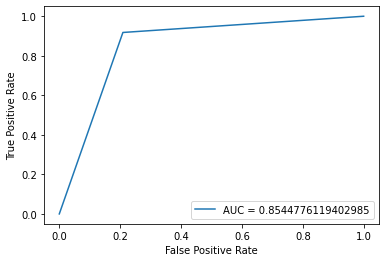

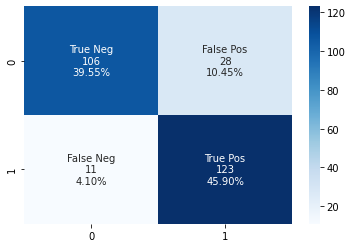

In [11]:
print("------------- PERFORMANCE NAIVE BAYES - LEMMATIZED -------------\n")
print("Training time ->", f_t0, " seconds \n")
evaluation_measures(y_test_lem, predictions_NB_lem, 'nb_lem')

### 1.1.2 Hyperparameter Tuning

In [12]:
#naive bayes GridSearchCV 
def naivebayes_tuning(x_train, y_train):
    #defined values for parameters
    grid_params = { 'alpha' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
    
    # k-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # grid search
    grid_search = GridSearchCV(ComplementNB(), 
                              grid_params,
                              verbose=1,
                              cv = kfold,
                              n_jobs= -1,
                              refit='accuracy',
                              scoring='accuracy')

    results = grid_search.fit(x_train, y_train)
    print(results.best_params_) #returns the best parameters

In [13]:
naivebayes_tuning(X_train_lem_Tfidf ,y_train_lem)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 1}


The best alpha value is 1, which is the default alpha, so therefore the  previously trained above is the best model, no changes needed to be done.

### 1.1.3 Prediction

In [14]:
#Prediction -Lemmatized
lem_tweets = tweet_df['lemmatized_tweet']
Tfidf_vect = TfidfVectorizer()
lem_tfidf = Tfidf_vect.fit_transform(lem_tweets)
predict = Naive_lem.predict(lem_tfidf)
tweet_df['Prediction_Lem'] = predict
tweet_df.to_csv("HashNaiveLem.csv", index=False)

In [15]:
nb_lem_df = pd.read_csv("HashNaiveLem.csv")
nb_lem_df.groupby('Prediction_Lem').describe()

author id                                                       \
                   count          mean           std        min           25%   
Prediction_Lem                                                                  
0                  644.0  2.697024e+17  4.824854e+17  2597581.0  1.285708e+08   
1                  696.0  2.170727e+17  4.612683e+17  1612011.0  1.131444e+08   

                                                        Category            \
                        50%           75%           max    count      mean   
Prediction_Lem                                                               
0               563994424.0  4.813761e+09  1.444056e+18    644.0  0.040373   
1               186365425.0  2.693266e+09  1.471594e+18    696.0  0.925287   

                                                   
                     std  min  25%  50%  75%  max  
Prediction_Lem                                     
0               0.196985  0.0  0.0  0.0  0.0  1.0  
1               0.263116  0.0  1.0  1.0  1.0  1.0

## 1.2 With Stemming

In [16]:
# fit the training dataset on the NB classifier
Naive_stem = ComplementNB()
t1 = time.time()
Naive_stem.fit(X_train_stem_Tfidf ,y_train_stem)
predictions_NB_stem = Naive_stem.predict(X_test_stem_Tfidf)
f_t1 = time.time()-t1
print(classification_report(y_test_stem, predictions_NB_stem))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       134
           1       0.82      0.93      0.87       134

    accuracy                           0.86       268
   macro avg       0.87      0.86      0.86       268
weighted avg       0.87      0.86      0.86       268



------------- PERFORMANCE NAIVE BAYES - STEMMING -------------

Training time -> 0.003523111343383789  seconds 

Accuracy -  0.8619402985074627
Precision -  0.8211920529801324
Recall/Sensitivity -  0.9253731343283582
F1-Score -  0.8701754385964913
Specificity -  0.7985074626865671
Error rate -  0.13805970149253732
AUC -  0.8619402985074627


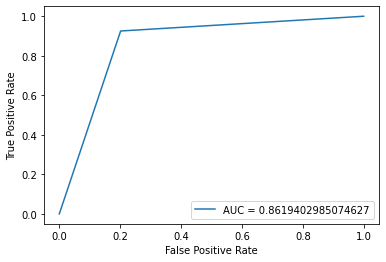

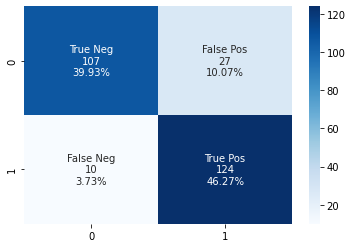

In [17]:
print("------------- PERFORMANCE NAIVE BAYES - STEMMING -------------\n")
print("Training time ->", f_t1, " seconds \n")
evaluation_measures(y_test_stem, predictions_NB_stem, 'nb_stem')

### 1.2.1 Hyperparameter Tuning

In [18]:
naivebayes_tuning(X_train_stem_Tfidf ,y_train_stem)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.1}


GridSearchCV returned alpha as 0.1. Let's apply the Complement Navie Bayes with alpha = 0.1

In [19]:
Naive_stem_tune = ComplementNB(alpha=0.1)
t01 = time.time()
Naive_stem_tune.fit(X_train_stem_Tfidf ,y_train_stem)
predictions_NB_stem_tune = Naive_stem_tune.predict(X_test_stem_Tfidf)
f_t01 = time.time()-t01
print(classification_report(y_test_stem, predictions_NB_stem_tune))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       134
           1       0.81      0.88      0.84       134

    accuracy                           0.84       268
   macro avg       0.84      0.84      0.84       268
weighted avg       0.84      0.84      0.84       268



------------- PERFORMANCE NAIVE BAYES - STEMMING -------------

Training time -> 0.003523111343383789  seconds 

Accuracy -  0.835820895522388
Precision -  0.8082191780821918
Recall/Sensitivity -  0.8805970149253731
F1-Score -  0.8428571428571429
Specificity -  0.7910447761194029
Error rate -  0.16417910447761194
AUC -  0.8358208955223881


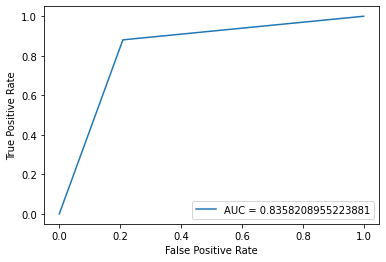

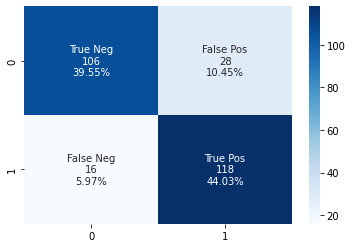

In [20]:
print("------------- PERFORMANCE NAIVE BAYES - STEMMING -------------\n")
print("Training time ->", f_t1, " seconds \n")
evaluation_measures(y_test_stem, predictions_NB_stem_tune, 'nb_stem')

Although GridSearchCV returned alpha as 0.1, the model gave a low performance compared to the initial stemmed CNB Model. 

### 1.2.2 Prediction

In [21]:
#Prediction - Stemming
df = pd.read_csv('HashNaiveLem.csv')
stem_tweets = df['stemming_tweet']
Tfidf_vect = TfidfVectorizer()
stem_tfidf = Tfidf_vect.fit_transform(stem_tweets)
predict = Naive_stem.predict(stem_tfidf)
tweet_df['Prediction_Stem'] = predict
tweet_df.to_csv("HashNaiveBayes-Predict.csv", index=False)

In [22]:
nb_stem_df = pd.read_csv("HashNaiveBayes-Predict.csv")
nb_stem_df.groupby('Prediction_Stem').describe()

author id                                                      \
                    count          mean           std        min          25%   
Prediction_Stem                                                                 
0                   643.0  2.679978e+17  4.809165e+17  2597581.0  125945841.0   
1                   697.0  2.187207e+17  4.629857e+17  1612011.0  113144389.0   

                                                         Category            \
                         50%           75%           max    count      mean   
Prediction_Stem                                                               
0                557414073.0  4.709025e+09  1.444056e+18    643.0  0.038880   
1                188283879.0  2.693266e+09  1.471594e+18    697.0  0.925395   

                 ...           Prediction_Lem                                \
                 ...  75%  max          count      mean       std  min  25%   
Prediction_Stem  ...                                                          
0                ...  0.0  1.0          643.0  0.013997  0.117569  0.0  0.0   
1                ...  1.0  1.0          697.0  0.985653  0.119003  0.0  1.0   

                                
                 50%  75%  max  
Prediction_Stem                 
0                0.0  0.0  1.0  
1                1.0  1.0  1.0  

[2 rows x 24 columns]

Overall best model was initial stemmed CNB

# 2. Support Vector Machine (SVM)

## 2.1 With Lemmatization

In [23]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM_lem = svm.SVC(kernel = 'linear')
t2 = time.time()
SVM_lem.fit(X_train_lem_Tfidf,y_train_lem)
# predict the labels on validation dataset
predictions_SVM_lem = SVM_lem.predict(X_test_lem_Tfidf)
f_t2 = time.time()-t2
print(classification_report(y_test_lem, predictions_SVM_lem))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       134
           1       0.82      0.87      0.84       134

    accuracy                           0.84       268
   macro avg       0.84      0.84      0.84       268
weighted avg       0.84      0.84      0.84       268



------------- PERFORMANCE SVM - LEMMATIZED -------------

Training time -> 0.24844598770141602  seconds 

Accuracy -  0.8395522388059702
Precision -  0.8226950354609929
Recall/Sensitivity -  0.8656716417910447
F1-Score -  0.8436363636363635
Specificity -  0.8134328358208955
Error rate -  0.16044776119402984
AUC -  0.8395522388059701


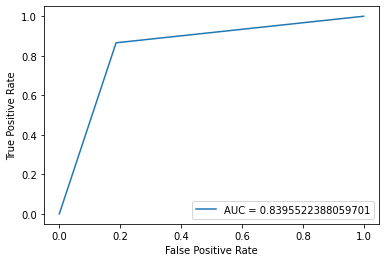

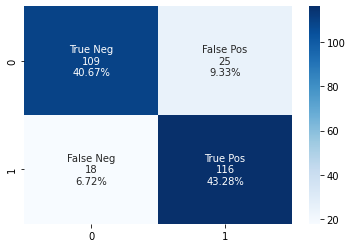

In [24]:
print("------------- PERFORMANCE SVM - LEMMATIZED -------------\n")
print("Training time ->", f_t2, " seconds \n")
evaluation_measures(y_test_lem, predictions_SVM_lem, 'svm_Lem')

### 2.1.1 Hyperparameter Tuning

In [25]:
def svm_tuning(x_train, y_train):
    grid_params = { 'C':[0.1,1,10],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                   'kernel': ['rbf', 'linear', 'sigmoid', 'poly']}
    
    # Set up the k-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True)

    grid_search = GridSearchCV(svm.SVC(), 
                              grid_params,
                              verbose=1,
                              cv = kfold,
                              n_jobs= -1,
                              refit='accuracy',
                              scoring='accuracy')

    results = grid_search.fit(x_train, y_train)
    print(results.best_params_)

In [26]:
svm_tuning(X_train_lem_Tfidf ,y_train_lem)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
{'C': 10, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}


Applying SVM with the returned best paramters

In [27]:
# fit the training dataset on the classifier
SVM_lem_tune = svm.SVC(C=10, degree = 1, gamma=1, kernel='rbf')
t3 = time.time()
SVM_lem_tune.fit(X_train_lem_Tfidf,y_train_lem)
# predict the labels on validation dataset
predictions_SVM_lem_tune = SVM_lem_tune.predict(X_test_lem_Tfidf)
f_t3 = time.time()-t3
print(classification_report(y_test_lem, predictions_SVM_lem_tune))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       134
           1       0.89      0.87      0.88       134

    accuracy                           0.88       268
   macro avg       0.88      0.88      0.88       268
weighted avg       0.88      0.88      0.88       268



------------- PERFORMANCE SVM AFTER TUNING - LEMMATIZED -------------

Training time -> 0.2638099193572998  seconds 

Accuracy -  0.8805970149253731
Precision -  0.8923076923076924
Recall/Sensitivity -  0.8656716417910447
F1-Score -  0.8787878787878788
Specificity -  0.8955223880597015
Error rate -  0.11940298507462686
AUC -  0.8805970149253731


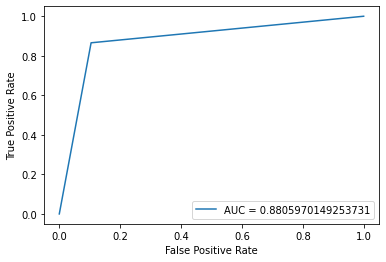

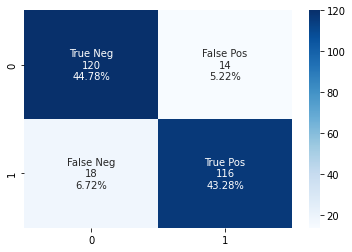

In [28]:
print("------------- PERFORMANCE SVM AFTER TUNING - LEMMATIZED -------------\n")
print("Training time ->", f_t3, " seconds \n")
evaluation_measures(y_test_lem, predictions_SVM_lem_tune, 'svm_Lem_tuning')

### 2.1.2 Prediction

In [29]:
#Prediction -Lemmatized
lem_tweets = tweet_df['lemmatized_tweet']
Tfidf_vect = TfidfVectorizer()
lem_tfidf = Tfidf_vect.fit_transform(lem_tweets)
predict = SVM_lem_tune.predict(lem_tfidf)
tweet_df['Prediction_Lem'] = predict
tweet_df.to_csv("HashSVMLem.csv", index=False)

In [30]:
svm_df = pd.read_csv("HashSVMLem.csv")
svm_df.groupby('Prediction_Lem').describe()

author id                                                      \
                   count          mean           std        min          25%   
Prediction_Lem                                                                 
0                  674.0  2.719522e+17  4.847782e+17  2597581.0  125584734.0   
1                  666.0  2.124251e+17  4.574156e+17  1612011.0  113144389.0   

                                                        Category            \
                        50%           75%           max    count      mean   
Prediction_Lem                                                               
0               557414073.0  4.851756e+09  1.444056e+18    674.0  0.026706   
1               186365425.0  2.693266e+09  1.471594e+18    666.0  0.978979   

                ...           Prediction_Stem                                \
                ...  75%  max           count      mean       std  min  25%   
Prediction_Lem  ...                                                           
0               ...  0.0  1.0           674.0  0.074184  0.262265  0.0  0.0   
1               ...  1.0  1.0           666.0  0.971471  0.166602  0.0  1.0   

                               
                50%  75%  max  
Prediction_Lem                 
0               0.0  0.0  1.0  
1               1.0  1.0  1.0  

[2 rows x 24 columns]

## 2.2 With Stemming

In [31]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM_stem = svm.SVC(kernel = 'linear')
t4 = time.time()
SVM_stem.fit(X_train_stem_Tfidf,y_train_stem)
# predict the labels on validation dataset
predictions_SVM_stem = SVM_stem.predict(X_test_stem_Tfidf)
f_t4 = time.time()-t4
print(classification_report(y_test_stem, predictions_SVM_stem))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       134
           1       0.87      0.87      0.87       134

    accuracy                           0.87       268
   macro avg       0.87      0.87      0.87       268
weighted avg       0.87      0.87      0.87       268



------------- PERFORMANCE SVM - STEMMING -------------

Training time -> 0.23643994331359863  seconds 

Accuracy -  0.8656716417910447
Precision -  0.8656716417910447
Recall/Sensitivity -  0.8656716417910447
F1-Score -  0.8656716417910447
Specificity -  0.8656716417910447
Error rate -  0.13432835820895522
AUC -  0.8656716417910447


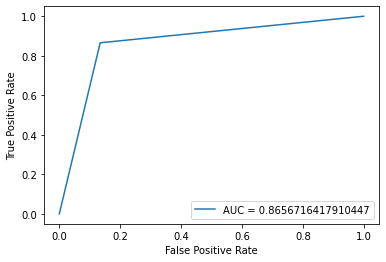

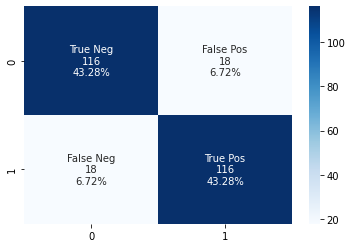

In [32]:
print("------------- PERFORMANCE SVM - STEMMING -------------\n")
print("Training time ->", f_t4, " seconds \n")
evaluation_measures(y_test_stem, predictions_SVM_stem, 'svm_stem')

### 2.2.1 Hyperparameter Tuning

In [33]:
svm_tuning(X_train_stem_Tfidf,y_train_stem)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
{'C': 10, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}


Applying SVM for stemming again with the returned best parameters

In [34]:
# fit the training dataset on the classifier
SVM_stem_tune = svm.SVC(C=10, gamma=1, degree=1, kernel='rbf')
t5 = time.time()
SVM_stem_tune.fit(X_train_stem_Tfidf,y_train_stem)
# predict the labels on validation dataset
predictions_SVM_stem_tune = SVM_stem_tune.predict(X_test_stem_Tfidf)
f_t5 = time.time()-t5
print(classification_report(y_test_stem, predictions_SVM_stem_tune))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       134
           1       0.89      0.84      0.86       134

    accuracy                           0.87       268
   macro avg       0.87      0.87      0.87       268
weighted avg       0.87      0.87      0.87       268



------------- PERFORMANCE SVM AFTER TUNING - STEMMING -------------

Training time -> 0.26150012016296387  seconds 

Accuracy -  0.8656716417910447
Precision -  0.8888888888888888
Recall/Sensitivity -  0.835820895522388
F1-Score -  0.8615384615384615
Specificity -  0.8955223880597015
Error rate -  0.13432835820895522
AUC -  0.8656716417910447


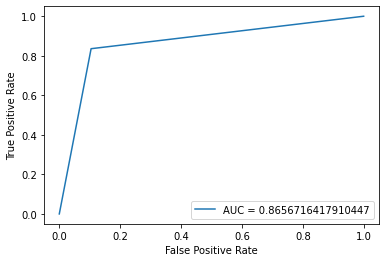

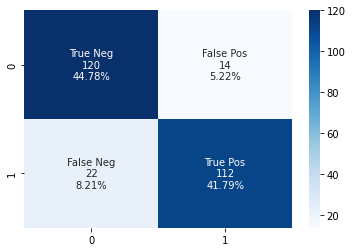

In [35]:
print("------------- PERFORMANCE SVM AFTER TUNING - STEMMING -------------\n")
print("Training time ->", f_t5, " seconds \n")
evaluation_measures(y_test_stem, predictions_SVM_stem_tune, 'svm_stem_tuning')

Tuning didn't do any changes to the Stemming SVM Model. Got default values for kernal(rbf), and C(1) as the best parameters. Only gamma got 1, but it didn't affect the model to do any changes.

### 2.2.2 Prediction

In [36]:
#Prediction - Stemming
tweet_df = pd.read_csv('HashSVMLem.csv')
stem_tweets = df['stemming_tweet']
Tfidf_vect = TfidfVectorizer()
stem_tfidf = Tfidf_vect.fit_transform(stem_tweets)
predict = SVM_stem.predict(stem_tfidf)
tweet_df['Prediction_Stem'] = predict
tweet_df.to_csv("HashSVM-Predict.csv", index=False)

In [37]:
svm = pd.read_csv("HashSVM-Predict.csv")
svm.groupby('Prediction_Stem').describe()

author id                                                      \
                    count          mean           std        min          25%   
Prediction_Stem                                                                 
0                   671.0  2.735454e+17  4.862138e+17  2597581.0  121690905.0   
1                   669.0  2.110940e+17  4.558154e+17  1612011.0  113144389.0   

                                                         Category            \
                         50%           75%           max    count      mean   
Prediction_Stem                                                               
0                557414073.0  4.882709e+09  1.444056e+18    671.0  0.043219   
1                186365425.0  2.693266e+09  1.471594e+18    669.0  0.958146   

                 ...           Prediction_Lem                                \
                 ...  75%  max          count      mean       std  min  25%   
Prediction_Stem  ...                                                          
0                ...  0.0  1.0          671.0  0.026826  0.161694  0.0  0.0   
1                ...  1.0  1.0          669.0  0.968610  0.174500  0.0  1.0   

                                
                 50%  75%  max  
Prediction_Stem                 
0                0.0  0.0  1.0  
1                1.0  1.0  1.0  

[2 rows x 24 columns]

Overall the lemmetized tuned SVM model had the highest performance

# 3. k-Nearest Neighbors (KNN)

## 3.1 With Lemmatization

In [38]:
def k_neighbors(x_train, y_train, x_test, y_test, name):
    
    #Finding a best value of k for better accuracy
    k_range=range(1,33)
    scores=[]
    
    #knn with cross validation
    for k in k_range:
        knn=KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring ='accuracy')
        scores.append(np.mean(cv_scores))
        
    #plotting line chart for accuracies
    plt.figure(figsize=(10,10))
    plt.plot(k_range, scores, 'o-')
    for x,y in zip(k_range, scores):
        label = "{0}".format(x)
        plt.annotate(str(label), (x,y), textcoords="offset points", xytext=(0,10), fontsize=14, ha='center') 
    plt.xlabel('k value')
    plt.ylabel('Accuracy')
    plt.savefig('KNNAccuracyCurve ' + str(name) + '.png') #saving plot
    plt.grid()

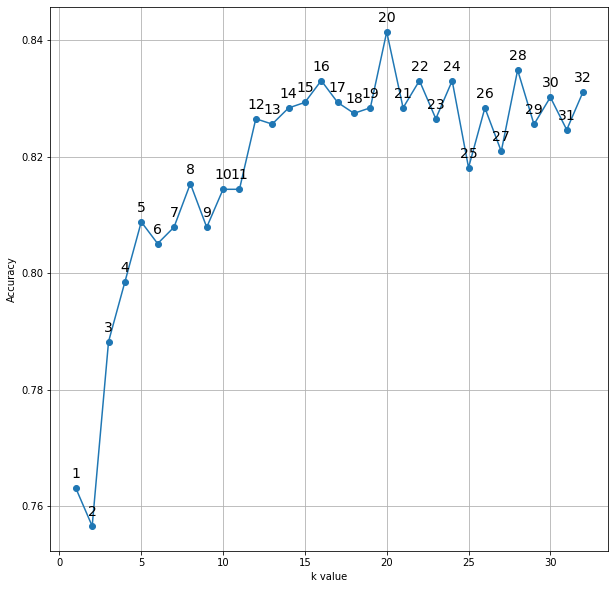

In [39]:
k_neighbors(X_train_lem_Tfidf,y_train_lem, X_test_lem_Tfidf, y_test_lem, 'lem')

Highest peak is at point 20, therefore let's apply KNN with n_neighbors as 20

In [40]:
#KNN
knn_lem = KNeighborsClassifier(n_neighbors = 20)
t6 = time.time()
knn_lem.fit(X_train_lem_Tfidf,y_train_lem)
predictions_knn_lem = knn_lem.predict(X_test_lem_Tfidf)
f_t6 = time.time()-t6
print(classification_report(y_test_lem, predictions_knn_lem))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       134
           1       0.80      0.84      0.82       134

    accuracy                           0.81       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.81      0.81      0.81       268



------------- PERFORMANCE KNN - LEMMATIZED -------------

Training time -> 0.020192861557006836  seconds 

Accuracy -  0.8134328358208955
Precision -  0.8
Recall/Sensitivity -  0.835820895522388
F1-Score -  0.8175182481751825
Specificity -  0.7910447761194029
Error rate -  0.1865671641791045
AUC -  0.8134328358208955


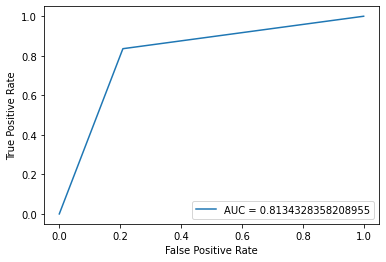

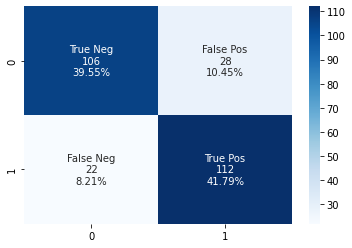

In [41]:
print("------------- PERFORMANCE KNN - LEMMATIZED -------------\n")
print("Training time ->", f_t6, " seconds \n")
evaluation_measures(y_test_lem, predictions_knn_lem, 'knn_lem')

### 3.1.1 Prediction

In [42]:
#Prediction -Lemmatized
lem_tweets = tweet_df['lemmatized_tweet']
Tfidf_vect = TfidfVectorizer()
lem_tfidf = Tfidf_vect.fit_transform(lem_tweets)
predict = knn_lem.predict(lem_tfidf)
tweet_df['Prediction_Lem'] = predict
tweet_df.to_csv("HashKNN-Predict.csv", index=False)

In [43]:
knn = pd.read_csv("HashKNN-Predict.csv")
knn.groupby('Prediction_Lem').describe()

author id                                                      \
                   count          mean           std        min          25%   
Prediction_Lem                                                                 
0                  654.0  2.607855e+17  4.829928e+17  1612011.0  116759147.0   
1                  686.0  2.248064e+17  4.612256e+17  2974941.0  115123902.0   

                                                        Category            \
                        50%           75%           max    count      mean   
Prediction_Lem                                                               
0               478779033.0  3.523302e+09  1.444056e+18    654.0  0.142202   
1               199795105.5  2.913931e+09  1.471594e+18    686.0  0.841108   

                ...           Prediction_Stem                                \
                ...  75%  max           count      mean       std  min  25%   
Prediction_Lem  ...                                                           
0               ...  0.0  1.0           654.0  0.120795  0.326138  0.0  0.0   
1               ...  1.0  1.0           686.0  0.860058  0.347180  0.0  1.0   

                               
                50%  75%  max  
Prediction_Lem                 
0               0.0  0.0  1.0  
1               1.0  1.0  1.0  

[2 rows x 24 columns]

## 3.2 With Stemming

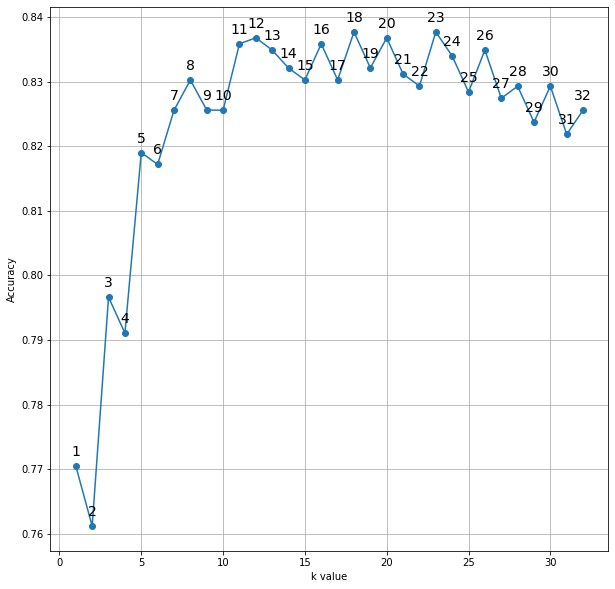

In [44]:
k_neighbors(X_train_stem_Tfidf,y_train_stem, X_test_stem_Tfidf, y_test_stem, 'stem')

Here two points 18 and 23 has highest peaks. Let's select 18 as the n_neighbors value

In [45]:
#KNN
knn_stem = KNeighborsClassifier(n_neighbors = 18)
t7 = time.time()
knn_stem.fit(X_train_stem_Tfidf,y_train_stem)
predictions_knn_stem = knn_stem.predict(X_test_stem_Tfidf)
f_t7 = time.time()-t7
print(classification_report(y_test_stem, predictions_knn_stem))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       134
           1       0.80      0.83      0.82       134

    accuracy                           0.81       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.81      0.81      0.81       268



------------- PERFORMANCE KNN - STEMMING -------------

Training time -> 0.019559383392333984  seconds 

Accuracy -  0.8134328358208955
Precision -  0.8043478260869565
Recall/Sensitivity -  0.8283582089552238
F1-Score -  0.8161764705882353
Specificity -  0.7985074626865671
Error rate -  0.1865671641791045
AUC -  0.8134328358208955


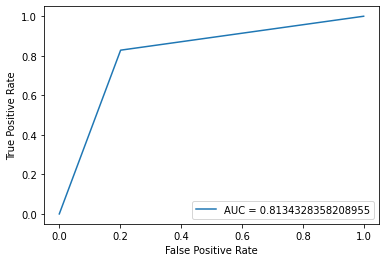

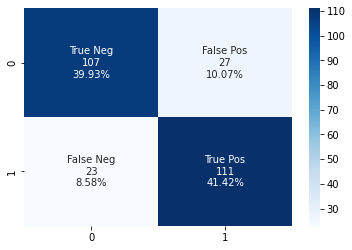

In [46]:
print("------------- PERFORMANCE KNN - STEMMING -------------\n")
print("Training time ->", f_t7, " seconds \n")
evaluation_measures(y_test_stem, predictions_knn_stem, 'knn_stem')

### 3.2.1 Predicition

In [47]:
#Prediction - Stemming
knn = pd.read_csv('HashKNN-Predict.csv')
stem_tweets = df['stemming_tweet']
Tfidf_vect = TfidfVectorizer()
stem_tfidf = Tfidf_vect.fit_transform(stem_tweets)
predict = knn_stem.predict(stem_tfidf)
tweet_df['Prediction_Stem'] = predict
tweet_df.to_csv("HashKNN-Predict.csv", index=False)

In [48]:
knn = pd.read_csv('HashKNN-Predict.csv')
knn.groupby('Prediction_Stem').describe()

author id                                         \
                    count          mean           std        min   
Prediction_Stem                                                    
0                   640.0  2.496633e+17  4.704264e+17  1612011.0   
1                   700.0  2.356949e+17  4.739409e+17  1612011.0   

                                                                        \
                          25%          50%           75%           max   
Prediction_Stem                                                          
0                1.162086e+08  459394353.5  3.356710e+09  1.444056e+18   
1                1.151239e+08  242235183.0  2.959077e+09  1.471594e+18   

                Category            ...           Prediction_Lem            \
                   count      mean  ...  75%  max          count      mean   
Prediction_Stem                     ...                                      
0                  640.0  0.131250  ...  0.0  1.0          640.0  0.064062   
1                  700.0  0.837143  ...  1.0  1.0          700.0  0.921429   

                                                    
                      std  min  25%  50%  75%  max  
Prediction_Stem                                     
0                0.245056  0.0  0.0  0.0  0.0  1.0  
1                0.269261  0.0  1.0  1.0  1.0  1.0  

[2 rows x 24 columns]

<h1>Reference - </h1>

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5